# Exploratory Data Analysis Using YouTube Video Data from Top Data Science Channels

## Introduction

YouTube, founded in 2005, has grown to become the second-largest search engine globally, processing over 3 billion searches per month [1]. Despite its popularity, the inner workings of the YouTube algorithm, such as how videos gain views and recommendations, remain somewhat of a mystery. YouTube boasts one of the most expansive and sophisticated recommendation systems in existence [2]. For new content creators, understanding why some videos succeed while others don't can be quite challenging. Numerous "myths" surround the factors contributing to a video's success on YouTube [3], such as the number of likes or comments, video duration, and other factors. It's also intriguing to explore emerging trends in specific niche topics covered by YouTube channels.

As someone who is looking into starting a new YouTube channel focused on the Pathfinder Second edition tabletop role playing system and as soneone who is also keen in involving myself in the data science/data analytics fields, I wanted to try to help myself see the market as well as polish my data and python skills. For the purpose of this project, I'll be focusing solely on Pathfinder channels. Thus, this project will delve into the statistical analysis of approximately the top 10 most successful Pathfinder 2e YouTube channels.

## Aims and Objectives

This project aims to achieve the following objectives:

- Gain proficiency in utilizing the YouTube API and extracting video data.
- Analyze video data to investigate common assumptions about YouTube video success, including:
        - Does the number of likes and comments impact a video's view count?
        - Is video duration a factor in views and user interaction (likes/comments)?
        - Does title length influence views?
        - How many tags do well-performing videos typically have, and what are the common tags used?
        - Across all the creators considered, how frequently do they upload new videos, and on which days of the week?
- Employ Natural Language Processing (NLP) techniques to explore trending topics, focusing on:
        - Identifying popular topics covered in videos (e.g., using word clouds for video titles).
        - Examining the questions posed in the video comments section.

## Steps of the Project

The project will progress through the following stages:

- Retrieve video metadata from the YouTube API for the top 10-15 data science channels. This involves several steps, including creating a developer key, requesting data, and transforming the responses into a usable format.
- Preprocess the data and engineer additional features for analysis.
- Conduct exploratory data analysis.
- Draw conclusions based on the findings.

## Dataset

### Data Selection 

I created my own dataset using the Google YouTube Data API version 3.0. The specific steps involved in data creation are detailed in section 2, "Creating the Dataset," below.

### Data Limitations

The dataset employed in this research is suitable for analysis and reflects real-world data. However, the Youtube channels selected are based only of my knowledge of and participation in the Pathfinder 2e community and may not be entirely accurate.

### Ethics of Data Source

According to the YouTube API's guidelines, the usage of the API is free of charge, as long as the application's requests adhere to the designated quota limit. "The YouTube Data API uses a quota to ensure that developers use the service as intended and do not create applications that unfairly reduce service quality or limit access for others." The default quota allocation for each application is 10,000 units per day, with the option to request additional quota by completing a form to the YouTube API Services if the limit is reached.

Since all data obtained from the YouTube API is public data, accessible to anyone on the internet, privacy concerns are not prominent in this case. Moreover, the data obtained is exclusively for research purposes and not for commercial gain.

In [1]:
# Imports

from googleapiclient.discovery import build # Youtube API
from dateutil import parser
import pandas as pd
from IPython.display import JSON
import isodate

# Data Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Creating the Dataset 

To start, I created a project in the Google Developers Console, then requested an API key, and enabled the Youtube API specifically so I could send API requests to Youtube API services. Then using https://syncwith.com/youtube/find-youtube-channel-id I found the channel ids for the handful of youtube channels I wanted to analyze. 

Then I created the functions for getting the channel statistics by means of the API.

In [2]:
api_key = '' # API key

channel_ids = ['UCYzLQM31VrbDEH8lNaBBLWQ', # The Rules Lawyer
               'UCIkfrKHG0Ps8yeo2LR1Cqjw', # NoNat1s
               'UCMo2HMsssNQ-AOM-ZT9yN7A', # deadly d8
               'UChtQk-wDX5F15f1dYGO5SQQ', # How It's Played
               'UCC562W7VxEyLFr_l5uwUIaA', # Frizz
               'UCPV4Vwo_msUIqjB3vUvX_7g', # Team Player Gaming
              ]

In [3]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
# Functions for getting channel statistics from the API

def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

### Get channel statistics 

Using 'get_channel_stats' to get the channel stats for the Youtube channels in scope

In [6]:
channel_data = get_channel_stats(youtube, channel_ids)

Now print out the data and take a look at the channel stats overview.

In [7]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Frizz,2180,244674,219,UUC562W7VxEyLFr_l5uwUIaA
1,Team Player Gaming,808,111349,214,UUPV4Vwo_msUIqjB3vUvX_7g
2,Nonat1s,49700,7854610,454,UUIkfrKHG0Ps8yeo2LR1Cqjw
3,deadly d8,3640,141837,68,UUMo2HMsssNQ-AOM-ZT9yN7A
4,How It's Played,21400,2558816,316,UUhtQk-wDX5F15f1dYGO5SQQ
5,The Rules Lawyer,28400,3042191,181,UUYzLQM31VrbDEH8lNaBBLWQ


The count columns in the channel_data are in string format, so we'll need to  convert them to numeric so we can do numeric operations on them

In [8]:
# Converting the columns describing counts from strings to numeric columns

numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)  # convert columns that should be numeric to numeric

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

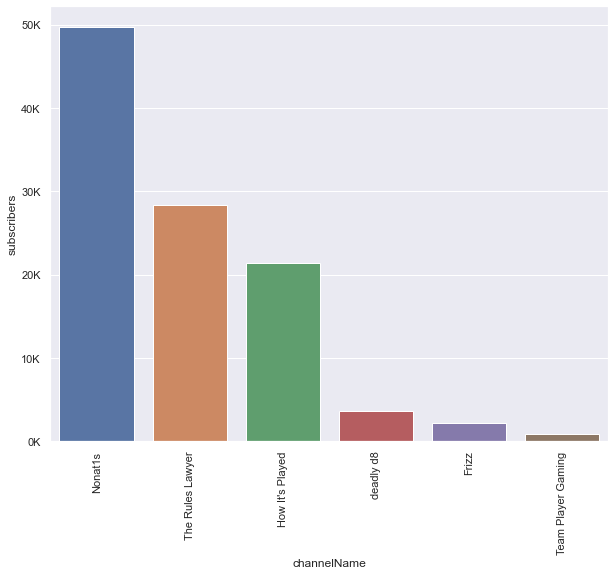

In [9]:
# Graphing results: Channel Names vs Subscriber count

sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Looking at channels considering the total number of views of the channels. 

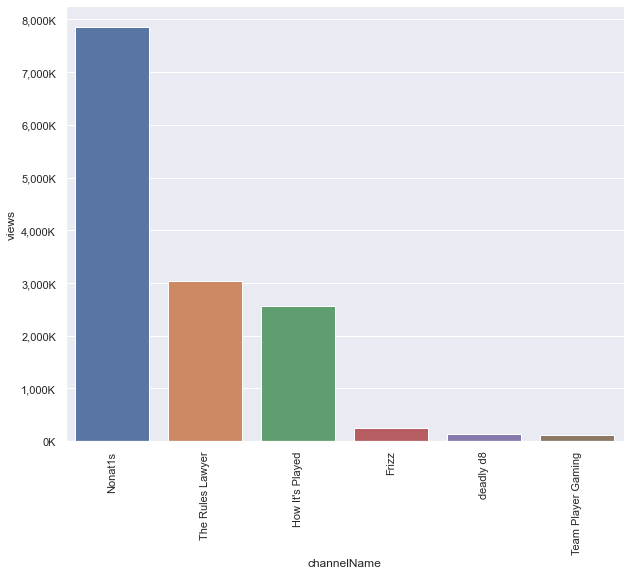

In [10]:
# Graphing results: Channel Names vs Views

ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

From here ,we are getting the video statistics for all the channels. There are a total of 1433 videos.

In [11]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)



Getting video information from channel: Frizz


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Team Player Gaming


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Nonat1s
Could not get comments for video -SOX01Kp9H4


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: deadly d8
Could not get comments for video 2H9nQy_efq0


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: How It's Played


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: The Rules Lawyer
Could not get comments for video gP6p_UBxVvc


C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_13904\3750072411.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [12]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,isaqzjQaa00,Frizz,Why Pathfinder 2e fights are EASY to make!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-10T13:00:34Z,715,53,None,13,PT10M8S,hd,false
1,2LVkmEJyM_o,Frizz,How the Pathfinder 2e Remaster could fix the A...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-08T13:01:01Z,780,69,None,20,PT8M24S,hd,false
2,Q3_akUXtmMk,Frizz,What makes MELEE and RANGED combat different!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-03T13:05:51Z,1078,76,None,15,PT5M4S,hd,false
3,E_D8_lJhj00,Frizz,Why you should be EXCITED for Pathfinder 2e's ...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-01T13:00:17Z,1685,111,None,23,PT10M9S,hd,false
4,CvxEQ6Nd1KY,Frizz,Lets talk about Paizocon (and play Risk of Rain)!,Welcome back folks! Today we're playing some R...,"[pathfinder, ttrpg, paizo, dnd, D&D, 2e, secon...",2023-05-31T01:12:55Z,243,14,None,1,PT3H43M37S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,MB7ut3qL_zI,The Rules Lawyer,Melding Might and Magic: Overview of Pathfinde...,We look at the new Magus class in Pathfinder 2...,"[2nd edition, Premiere_Elements_2021, magus, p...",2021-08-30T10:27:40Z,20710,669,None,67,PT34M11S,hd,false
1447,PRq0VaN1-XE,The Rules Lawyer,This Ain't D&D: Tactics + Strategies for Pathf...,Here we look at the notorious difficulty of Pa...,"[Premiere_Elements_2021, pathfinder 2e, pathfi...",2021-08-26T19:22:25Z,32414,1311,None,182,PT1H1M11S,hd,false
1448,fLnmENaQykE,The Rules Lawyer,Martials and clerics are FUN in Pathfinder 2e!...,Playing a martial character or a cleric doesn'...,"[pathfinder rpg, pf2e, pf2, 2nd edition, pathf...",2021-08-19T21:40:47Z,8760,337,None,51,PT54M19S,hd,false
1449,zBb10JowP30,The Rules Lawyer,Understand Character Creation in Pathfinder 2e,"(This is a reposting with improved audio, but ...","[pf2, pf2e, pathfinder rpg, pathfinder, 2nd ed...",2021-08-18T20:29:03Z,31876,1059,None,57,PT32M55S,hd,false


In [13]:
comments_df

,video_id,comments
0,isaqzjQaa00,[It's the perfect system until them there barb...
1,2LVkmEJyM_o,[Chirugeon could get into body-modification vi...
2,Q3_akUXtmMk,[I will never not like your videos! Concise an...
3,E_D8_lJhj00,[Finally I will be able to make an atomic ant ...
4,CvxEQ6Nd1KY,[I am extreamely consered about powercreep in ...
...,...,...
1443,MB7ut3qL_zI,[Which hybrid study for the Magus are other pe...
1444,PRq0VaN1-XE,[Is it possible to use reactions after taking ...
1445,fLnmENaQykE,[A FEW CORRECTIONS: \n8:10 - Sneaking to a pla...
1446,zBb10JowP30,[I've been binging your videos. Do you address...


In [14]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_channels.csv')
comments_df.to_csv('comments_data_top10_channels.csv')

In [15]:
# Analysis Ideas 
#  * Views per video
#  * Likes and comments vs views
#  * Title Length vs views 
#  * Video Duration
#  * Video Upload Schedules
#  * Tags
#  * Tags vs views

## Data Pre-processing and feature engineering

Checking dataframe for empty values

In [16]:
video_df.isnull().any() # any nulls?

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [17]:
video_df.publishedAt.sort_values().value_counts()

2023-03-23T13:00:34Z    2
2019-01-25T16:21:14Z    1
2022-07-20T20:40:51Z    1
2022-07-26T14:27:41Z    1
2022-07-25T14:00:30Z    1
                       ..
2021-09-06T14:14:55Z    1
2021-09-06T08:06:29Z    1
2021-09-04T21:29:12Z    1
2021-09-03T15:30:03Z    1
2023-06-14T15:30:07Z    1
Name: publishedAt, Length: 1450, dtype: int64

In [18]:
video_df.dtypes # checking data types

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [19]:
# Checked the data types and count columns such as view counts and comment count are strings not numerical
# convert the proper columns to numeric

cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

## Enriching data 

So I want to enrich the data for further analyses, for example:
- To create published date column with another column showing the day in the week the video was published, which will be useful for later analysis.
- To convert video duration to seconds instead of the current default string format
- To calculate number of tags for each video
- To calculate comments and likes per 1000 view ratio
- To calculate title character length



In [20]:
# Create Publish Day of the Week column
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [21]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,608.0,PT10M8S
1,504.0,PT8M24S
2,304.0,PT5M4S
3,609.0,PT10M9S
4,13417.0,PT3H43M37S
...,...,...
1446,2051.0,PT34M11S
1447,3671.0,PT1H1M11S
1448,3259.0,PT54M19S
1449,1975.0,PT32M55S


In [23]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [24]:
# comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [25]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [26]:
# looking at the dataset to be sure everything went okay

video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount,likeRatio,commentRatio,titleLength
0,isaqzjQaa00,Frizz,Why Pathfinder 2e fights are EASY to make!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-10 13:00:34+00:00,715.0,53.0,NaN,13.0,PT10M8S,hd,false,Saturday,608.0,34,74.125874,18.181818,42
1,2LVkmEJyM_o,Frizz,How the Pathfinder 2e Remaster could fix the A...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-08 13:01:01+00:00,780.0,69.0,NaN,20.0,PT8M24S,hd,false,Thursday,504.0,28,88.461538,25.641026,55
2,Q3_akUXtmMk,Frizz,What makes MELEE and RANGED combat different!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-03 13:05:51+00:00,1078.0,76.0,NaN,15.0,PT5M4S,hd,false,Saturday,304.0,34,70.500928,13.914657,45
3,E_D8_lJhj00,Frizz,Why you should be EXCITED for Pathfinder 2e's ...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-01 13:00:17+00:00,1685.0,111.0,NaN,23.0,PT10M9S,hd,false,Thursday,609.0,34,65.875371,13.649852,59
4,CvxEQ6Nd1KY,Frizz,Lets talk about Paizocon (and play Risk of Rain)!,Welcome back folks! Today we're playing some R...,"[pathfinder, ttrpg, paizo, dnd, D&D, 2e, secon...",2023-05-31 01:12:55+00:00,243.0,14.0,NaN,1.0,PT3H43M37S,hd,false,Wednesday,13417.0,10,57.613169,4.115226,49


## Exploratory Data Analysis

### Views distribution per channel

With the video statistics for all channel, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Other channels might have more evenly distribution views per video.

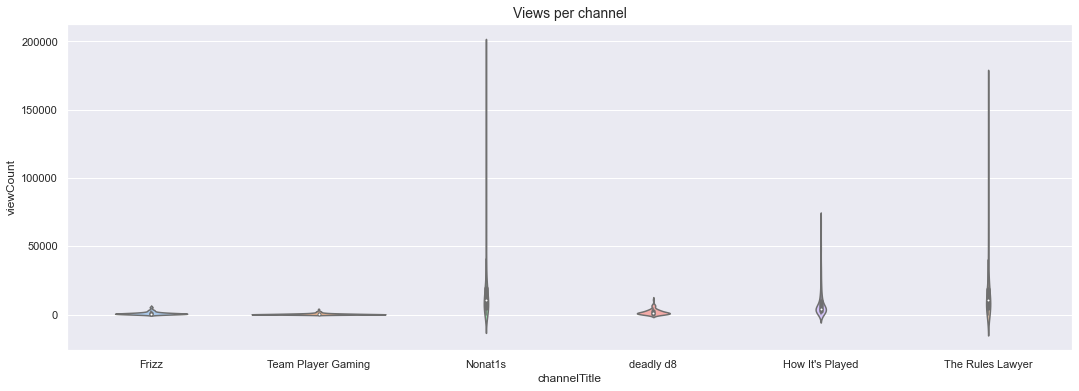

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagCount,likeRatio,commentRatio,titleLength
0,isaqzjQaa00,Frizz,Why Pathfinder 2e fights are EASY to make!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-10 13:00:34+00:00,715.0,53.0,NaN,13.0,PT10M8S,hd,false,Saturday,608.0,34,74.125874,18.181818,42
1,2LVkmEJyM_o,Frizz,How the Pathfinder 2e Remaster could fix the A...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-08 13:01:01+00:00,780.0,69.0,NaN,20.0,PT8M24S,hd,false,Thursday,504.0,28,88.461538,25.641026,55
2,Q3_akUXtmMk,Frizz,What makes MELEE and RANGED combat different!,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-03 13:05:51+00:00,1078.0,76.0,NaN,15.0,PT5M4S,hd,false,Saturday,304.0,34,70.500928,13.914657,45
3,E_D8_lJhj00,Frizz,Why you should be EXCITED for Pathfinder 2e's ...,Welcome back folks! Today we're talking about ...,"[Pathfinder, Pathfinder 2e, TTRPG, equipment, ...",2023-06-01 13:00:17+00:00,1685.0,111.0,NaN,23.0,PT10M9S,hd,false,Thursday,609.0,34,65.875371,13.649852,59
4,CvxEQ6Nd1KY,Frizz,Lets talk about Paizocon (and play Risk of Rain)!,Welcome back folks! Today we're playing some R...,"[pathfinder, ttrpg, paizo, dnd, D&D, 2e, secon...",2023-05-31 01:12:55+00:00,243.0,14.0,NaN,1.0,PT3H43M37S,hd,false,Wednesday,13417.0,10,57.613169,4.115226,49


In [27]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(x=video_df['channelTitle'], y=video_df['viewCount'], data=video_df, palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()
video_df.head()

### Best Performing Videos

These are the videos in the collection with the highest number of views.

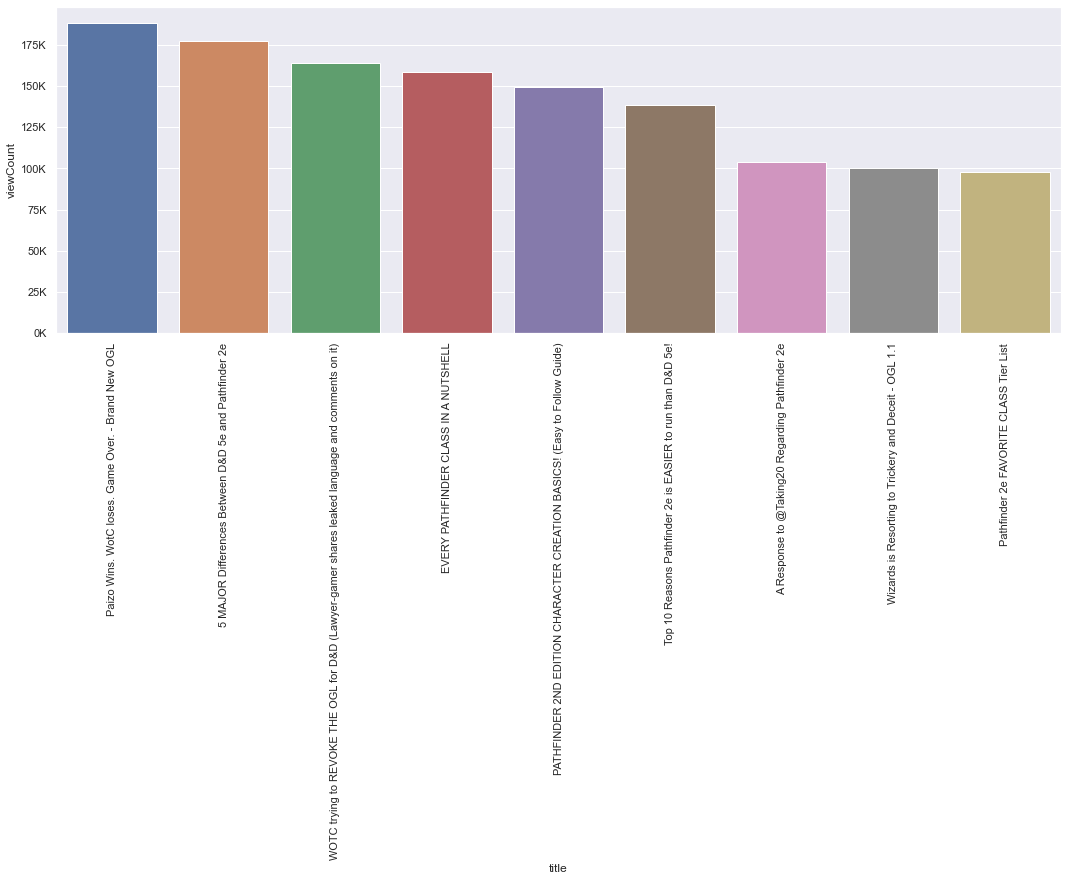

In [46]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # thank you Google
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

### Worst Performing Videos

Conversely these are the videos in the collection with the least number of views.

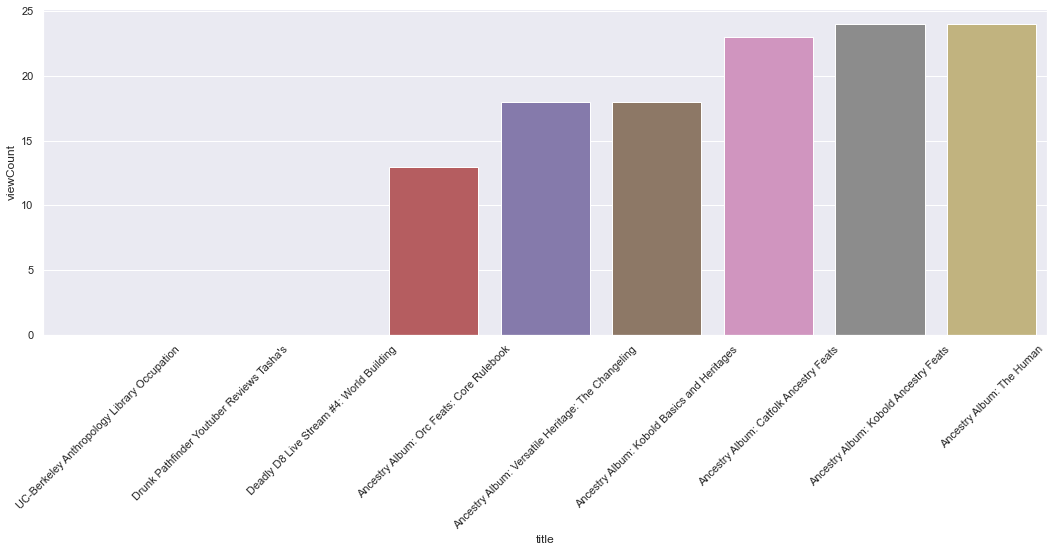

In [48]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # thank you Google
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x)))

### Does number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

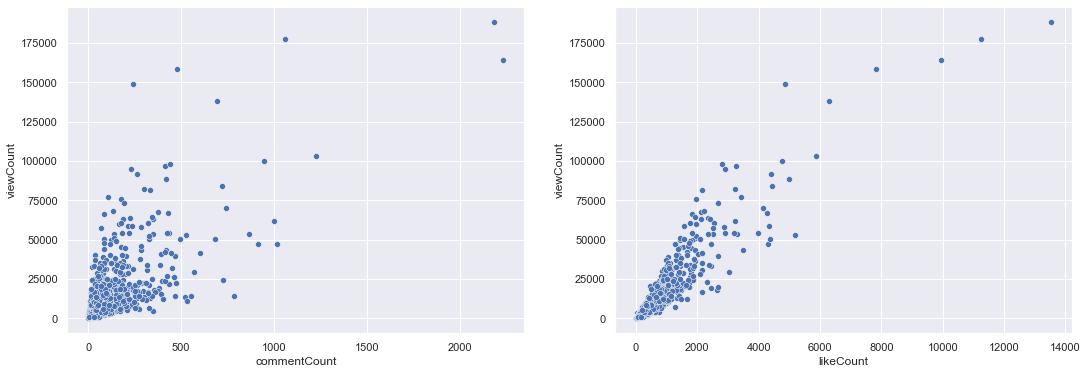

In [30]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

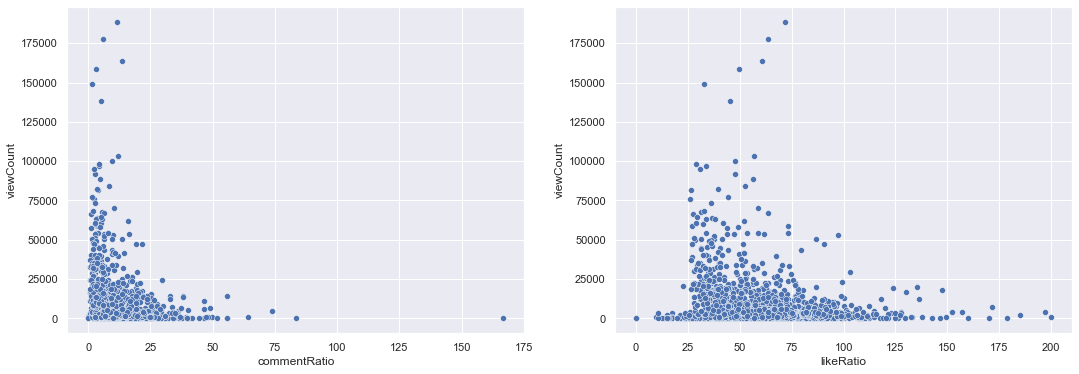

In [32]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

Upon adjusting for the total number of views, the previously observed correlation becomes less evident. The association between comments and views seems to disappear entirely, as numerous videos garner millions of views but receive very few comments, while some videos with a small number of views exhibit higher levels of interaction. It is worth noting that leaving a comment requires more effort compared to views and likes, and typically comments tend to decline as videos age.

Regarding the relationship between likes and views, there still appears to be a slight positive correlation, albeit subtle. This suggests that as the number of views increases, more individuals are inclined to click the like button. This finding aligns with the concept of social proof, which suggests that people are more likely to favor products or content that have already received approval from a large number of others.

### Does the video duration matter for views and interaction (likes/ comments)?

Taking a glance at the histogram below, we can observe that most videos tend to fall within the 300 to 1200-second mark, which translates to roughly 5 to 20 minutes in duration. However, in order to accommodate for any excessively long videos, such as potential streaming content, it has been deemed necessary to impose a duration limit of 10,000 seconds.


<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

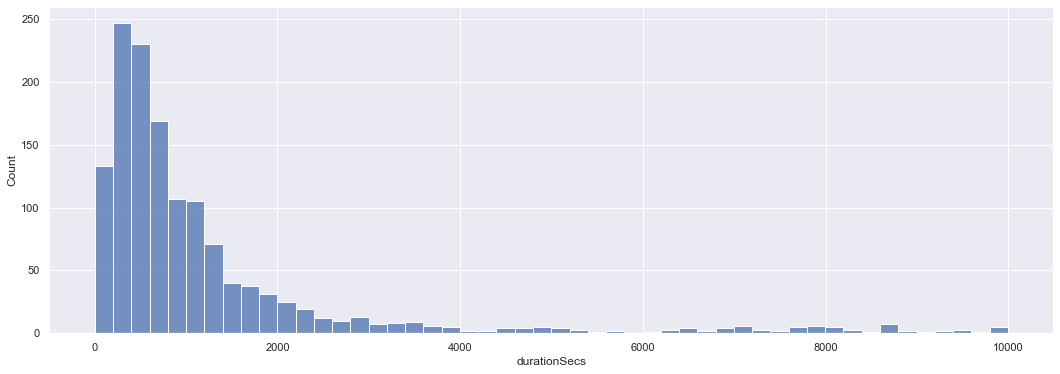

In [50]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=50)


Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.


<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

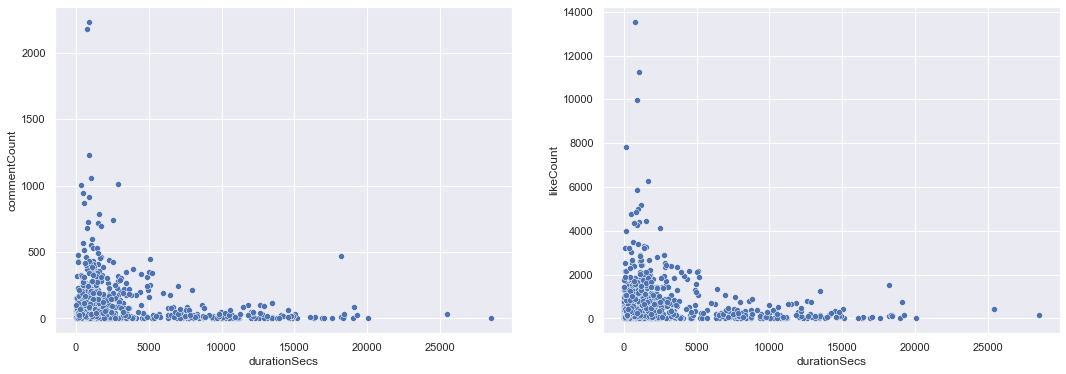

In [34]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below.

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

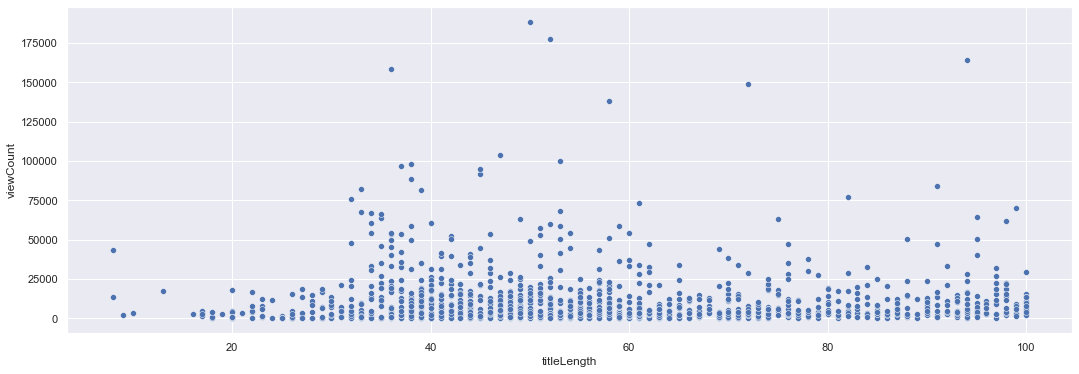

In [35]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

### Wordcloud for video titles

I'm curious to explore the content that creators are focusing on in their videos and discover the key terms that appear most frequently in their video titles. To achieve this, I'll generate a wordcloud showcasing the most common words used. However, before diving into the analysis, it's important to eliminate stopwords like "you," "I," "the," and others that don't significantly contribute to the overall meaning of the title.

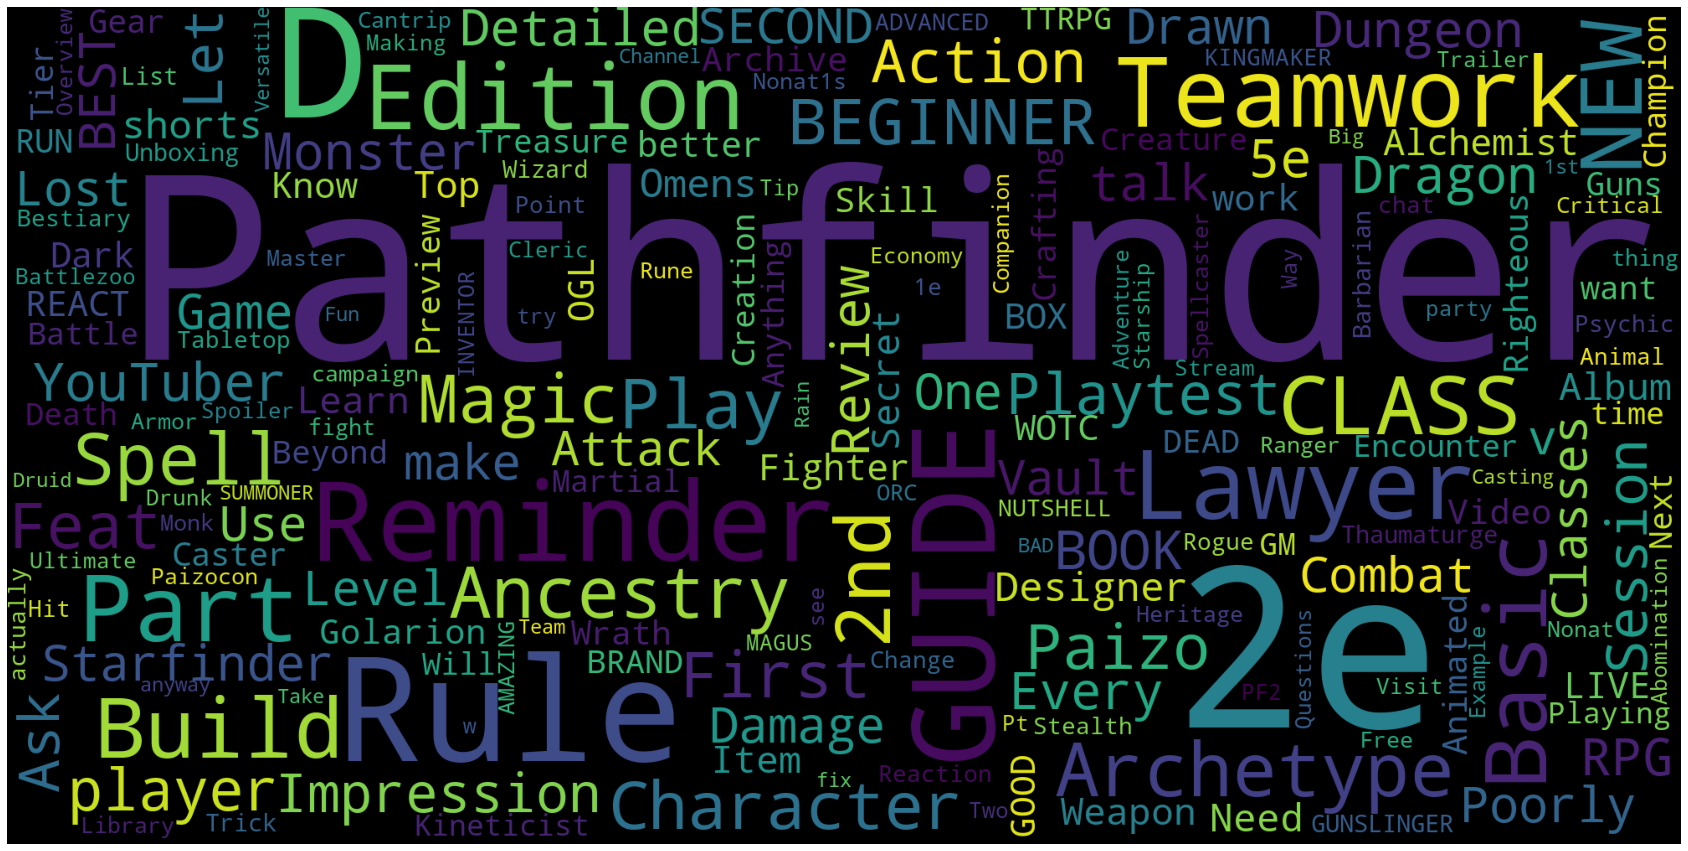

In [39]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

We can see that the most common words are Pathfinder, 2e, Rule, Reminder and Teamwork

### Number of tags vs views

It seems that most videos have between 5 and 40 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

<AxesSubplot:xlabel='tagCount', ylabel='viewCount'>

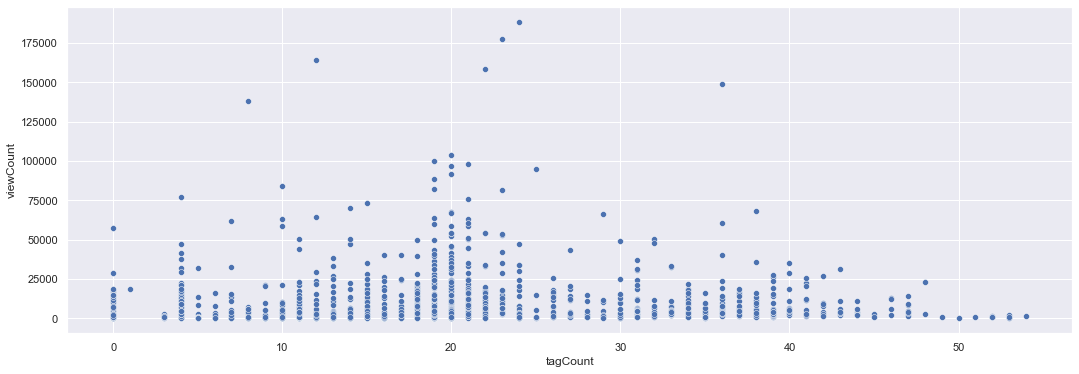

In [40]:
sns.scatterplot(data = video_df, x = "tagCount", y = "viewCount")

### Upload Schedule

It's interesting to see that more videos are uploaded on Mondays and Thursday. Fewer videos are uploaded on Sundays. 

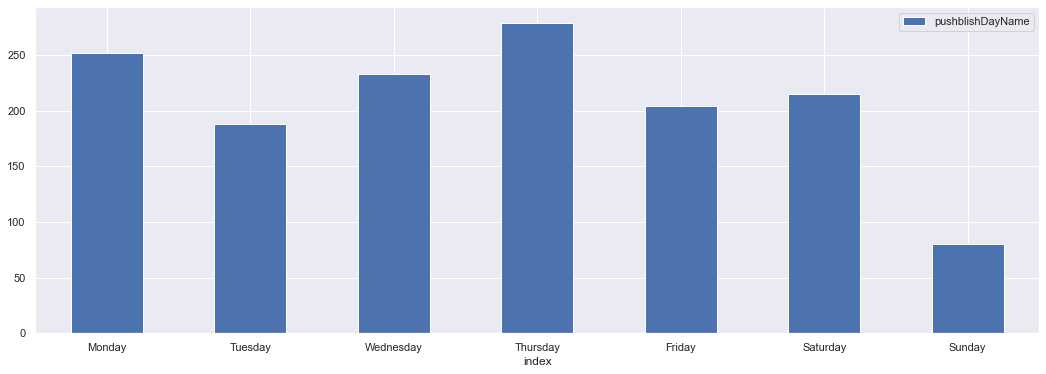

In [41]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.

In [42]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

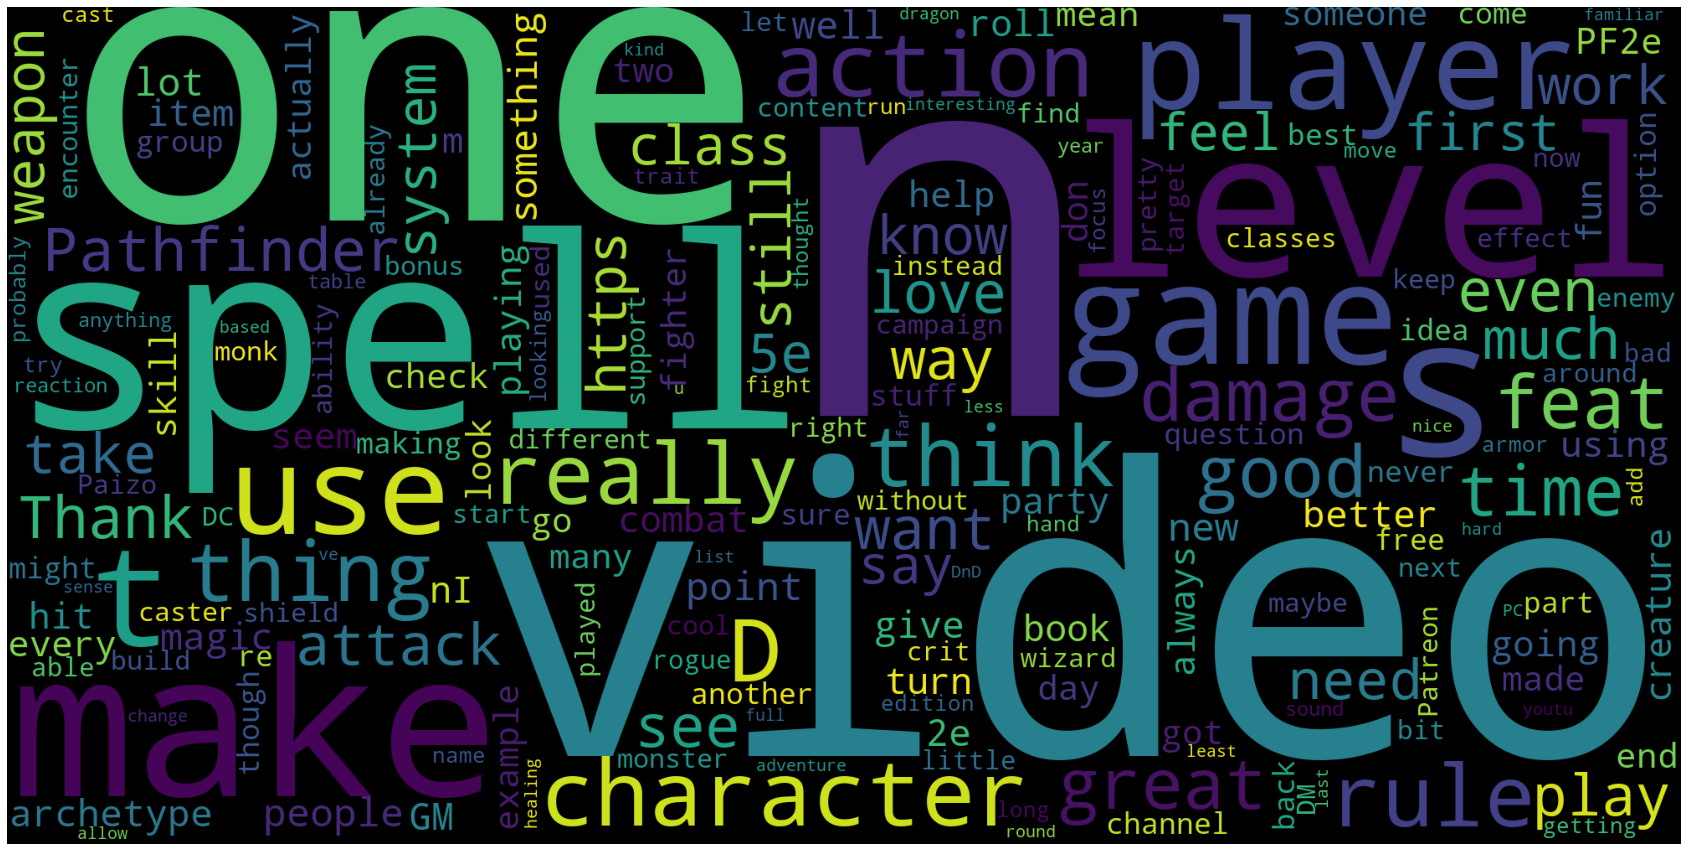

In [43]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

## Conclusions and future research ideas

In this project, we have explored the video data of some Pathfinder channels and revealed many interesting findings for anyone who may be starting out with a Youtube channel:

- The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.
- Most videos have between 5 and 40 tags.
- Most-viewed videos tend to have average title length of 30-70 characters. Too short or too long titles seem to harm viewership.
- Videos are usually uploaded on Mondays and Thursday. Weekends and Sunday in particular is not a popular time for posting new videos.
- Comments on videos are generally positive, 

### Project limitation:

The findings should also be taken with a grain of salt for a number of reasons:
- The number of videos is quite small (the dataset has only ~3,700 videos)
- I have only considered the first 10 comments on each video, which might not be representative for all comments
- There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is

### Ideas for future research:

To expand and build on this research project, one can:
- Expand the dataset to also smaller channels in data science niche
- Do sentiment analysis on the comments and find out which videos get more positive comments and which videos get less positive comments
- Do market research by analyzing questions in the comment threads and identifying common questions/ market gaps which could potentially filled
- Conduct this research for other niches (e.g. vlogs or beauty channels), to compare different niches with each other to see the different patterns in viewership and video characteristics.

References/ Resources used:

[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3

[3] P. Covington, J. Adams, E. Sargin. The youtube video recommendation system. In Proceedings of the Fourth ACM Conference on Recommender Systems, RecSys '16, pages 191-198, New York, NY, USA, 2016. ACM.
